### 目的
DataLoaderによるモデルの学習を行うために, pytorchによるMNISTデータセットの分類モデルを作成する. 
> 本コードは, [PyTorchでMNISTを扱ってみた (機械学習)](https://qiita.com/Uta10969/items/24d85860ffcd724de9eb)に従って作成する.

### ライブラリのインポート

#### PyTorch

| ライブラリ |詳細|
| - | - |
| torch | PyTorch全体 |
| torch.nn | ネットワークモデルの構築全般. Linearなど. |
| torch.nn.functional | 関数のパッケージ. reluなどの非線形関数. |
| torch.optim | 最適化 |
| torchvision | 画像処理？ | 
| torchvision.transforms | 画像変換機能. 画像データをtorch.Tensorなどに変換する. |

In [2]:
import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

print('torch version ==', torch.__version__)

torch version == 2.0.0


#### 汎用ライブラリ

In [3]:
import numpy as np
import matplotlib.pyplot as plt

### 乱数シードの固定

> 乱数固定によるPyTorchの再現性に関しては, [ここ](https://qiita.com/north_redwing/items/1e153139125d37829d2d)を参照. (特に, colab環境でcuda gpuを使う場合)

In [4]:
def setup_all_seed(seed=0):
    # numpyの乱数シード
    np.random.seed(seed)

    # torchの乱数シード
    torch.manual_seed(seed)

    # cuda関連のようだからいらない
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True

### MNIST Dataset
- 画像枚数（学習用）：60000枚
- 画像枚数（テスト用）：10000枚
- 画像サイズ：28×28, 0~1のグレースケール

#### データセットのロード

In [5]:
# 訓練データ
train_dataset = torchvision.datasets.MNIST(root='./MNIST', 
                                           train=True, 
                                           transform=transforms.ToTensor(), 
                                           download=True)

# 検証データ
test_dataset  = torchvision.datasets.MNIST(root='./MNIST', 
                                           train=False, 
                                           transform=transforms.ToTensor(), 
                                           download=True)

#### 訓練データの確認

訓練データセット内, データ数: 60000
fig     : tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000

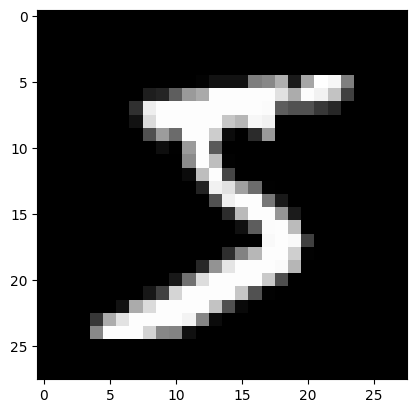

In [6]:
print(f'訓練データセット内, データ数: {len(train_dataset)}')

fig, label = train_dataset[0]
print(f'fig     : {fig}')
print(f'fig.Size: {fig.shape}')
print(f'label   : {label}')

# fig.view(-1, 28): torch.Size([1, 28, 28]) → torch.Size([28, 28])
plt.imshow(fig.view(-1, 28), cmap='gray')

### ミニバッチ学習の準備：データローダー
- バッチ学習：全てのデータセットを投入してモデルを学習する. 
- オンライン学習：データをランダムに1件ずつ投入してモデルを学習する. 
- ミニバッチ学習：データセットを小さいグループに分割し, グループを1つずつ投入してモデルを学習する. 

In [7]:
batch_size = 256    # 2の累乗で指定していることが多い. データセットを割り切れる必要はないみたい. 

# データローダー
train_loader = utils.data.DataLoader(dataset=train_dataset,  # type: ignore
                                     batch_size=batch_size, 
                                     shuffle=True)
test_loader  = utils.data.DataLoader(dataset=test_dataset,  # type: ignore
                                     batch_size=batch_size, 
                                     shuffle=True)

### ネットワークモデルの定義
画像分類なのに, 今回はMLPでモデルを構築するみたい. 
モデルは, 1枚の画像を受け取り, それに対して10種の数字適応率を出力. 

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden1_size)
        # print(f'fc1 weight: {self.fc1.weight} \nfc1 bias: {self.fc1.bias}\n')

        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        # print(f'fc2 weight: {self.fc2.weight} \nfc2 bias: {self.fc2.bias}\n')

        self.fc3 = nn.Linear(hidden2_size, output_size)
        # print(f'fc3 weight: {self.fc3.weight} \nfc3 bias: {self.fc3.bias}\n')

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [9]:
input_size = 28 * 28    # 画像サイズ

hidden1_size = 1024
hidden2_size = 512

output_size = 10        # 0~9の10種分類

device = 'cpu'
# device = 'gpu' if torch.cuda.is_available() else 'cpu'

model = Net(input_size, hidden1_size, hidden2_size, output_size).to(device)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


### 損失関数とオプティマイザー
- 損失関数
  - CrossEntropyLoss：交差エントロピー誤差関数
  > LogSoftmax + NLLLoss と CrossEntropyLoss は同様の計算を行う. [参考](https://qiita.com/y629/items/1369ab6e56b93d39e043)
  
  今回は変数宣言しない. (急に`criterion`とか使われてもわからん)

- オプティマイザー
  - SGD：確率的勾配降下法    ← 今回はこっち
  - Adam：

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

### 訓練関数の定義

In [1]:
def train_model(model, train_loader, optimizer, device):

    train_loss = 0.0
    num_train = 0

    # 訓練モードに設定
    model.train()

    for images, labels in train_loader:
        # batch_sizeをカウント
        num_train += len(labels)

        # モデル用入力サイズに変換し, deviceに応じて変換
        images, labels = images.view(-1, 28*28).to(device), labels.to(device)

        # 最適化勾配の初期化
        optimizer.zero_grad()

        # 推論
        outputs = model(images)

        # 損失
        loss = F.cross_entropy(outputs, labels)

        # 誤差逆伝播
        loss.backward()

        # パラメータ更新
        optimizer.step()

        # lossの加算
        train_loss += loss.item()

    # loss平均
    train_loss = train_loss / num_train

    return train_loss

### 評価関数の定義

In [11]:
def test_model(model, test_loader, device):

    test_loss = 0.0
    num_test = 0

    # 評価モードに設定
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            # batch_sizeをカウント
            num_test += len(labels)

            # モデル用入力サイズに変換し, deviceに応じて変換
            images, labels = images.view(-1, 28*28).to(device), labels.to(device)

            # 推論
            outputs = model(images)

            # 損失
            loss = F.cross_entropy(outputs, labels)
            
            # lossの加算
            test_loss += loss.item()
            
    # loss平均
    test_loss = test_loss / num_test

    return test_loss

### モデル学習を行う関数の定義

In [12]:
def learning(model, train_loader, test_loader, optimizer, num_epochs, device):

    train_loss_list = []
    test_loss_list  = []

    for epoch in range(1, num_epochs+1):

        train_loss = train_model(model, train_loader, optimizer, device)
        test_loss  = test_model(model, test_loader, device)

        print(f'epoch: {epoch} | train_loss: {train_loss:.5f}, test_loss: {test_loss:.5f}')

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

    return train_loss_list, test_loss_list

### 実行

In [13]:
num_epochs = 10
train_loss_list, test_loss_list = learning(model, train_loader, test_loader, optimizer, num_epochs, device)

epoch: 1 | train_loss: 0.00883, test_loss: 0.00873
epoch: 2 | train_loss: 0.00796, test_loss: 0.00728
epoch: 3 | train_loss: 0.00605, test_loss: 0.00511
epoch: 4 | train_loss: 0.00442, test_loss: 0.00399
epoch: 5 | train_loss: 0.00343, test_loss: 0.00272
epoch: 6 | train_loss: 0.00238, test_loss: 0.00209
epoch: 7 | train_loss: 0.00196, test_loss: 0.00179
epoch: 8 | train_loss: 0.00174, test_loss: 0.00161
epoch: 9 | train_loss: 0.00160, test_loss: 0.00150
epoch: 10 | train_loss: 0.00151, test_loss: 0.00143


### 学習遷移

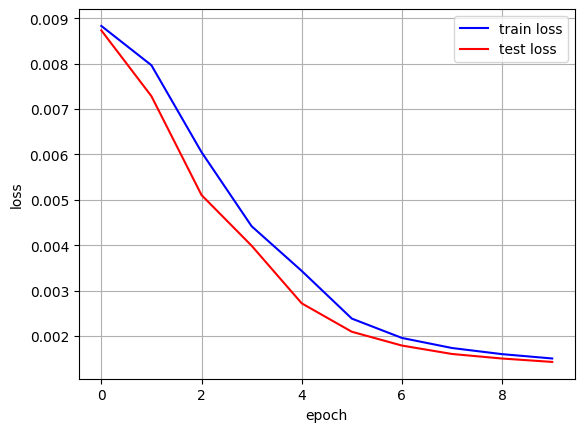

In [14]:
plt.plot(range(len(train_loss_list)), train_loss_list, c='b', label='train loss')
plt.plot(range(len(test_loss_list)), test_loss_list, c='r', label='test loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

### 学習結果の確認

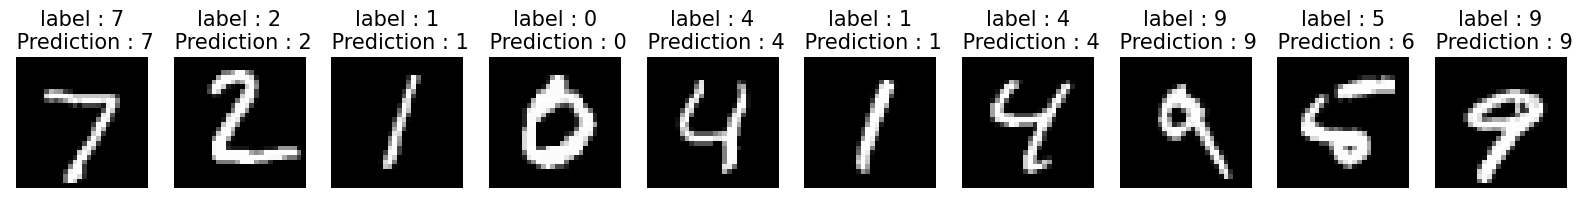

In [15]:
plt.figure(figsize=(20, 10))
for i in range(10):
    image, label = test_dataset[i]
    image = image.view(-1, 28*28).to(device)

    # 推論
    prediction_label = torch.argmax(model(image))

    ax = plt.subplot(1, 10, i+1)

    plt.imshow(image.detach().to('cpu').numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title('label : {}\n Prediction : {}'.format(label, prediction_label), fontsize=15)
plt.show()